# Responsible Prompting

## Recipe: Recommend Thresholds

This notebook shows how different sentence transformers and prompting styles can lead to different similarity metrics. Hence, a similarity-based recommendation should also be aware of that. With that in mind, here we show how to select a good starting point in terms of thresholds based on a set of prompts and a sentence transformer you plan to use.

### Thresholds

- **add_lower_threshold**: The lower threshold is used to select centroids of sentences based on the similarity of the provided input and the centroid of existing clusters of sentences based on values. The default value for the lower threshold is 0.3.

- **add_upper_threshold**: The upper sentence threshold is being used as a ceiling value to avoid redundance, meaning that we will not recommend adding something that is already there. The default value for the upper threshold is 0.5.

- **remove_lower_threshold**: The lower threshold is used to select centroids of sentences based on the similarity of the provided input and the centroid of existing clusters of sentences based on values.. The default value for the lower removal threshold is 0.3.

- **remove_upper_threshold**: An upper removal threshold limit is used to prevent false positives and remove a sentence in the prompt similar to one of our adversarial prompts. The default value for the upper removal threshold is 0.5.


In sum, we should try to maximize meaningful recommendations for inclusion (i.e., we must retrieve meaningful and yet not present comments) while maximizing the similarity with harmful sentences while minimizing false positives.

In [27]:
import os
import os.path
import requests
import json
import math
import re
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# from umap import UMAP
# import tensorflow as tf
# from umap.parametric_umap import ParametricUMAP, load_ParametricUMAP

### Loading hugging face token from .env file

In [28]:
if os.getenv("COLAB_RELEASE_TAG"):
    COLAB = True
    from google.colab import userdata
    HF_TOKEN = userdata.get('HF_TOKEN')
else:
    COLAB = False
    from dotenv import load_dotenv
    load_dotenv()
    HF_TOKEN = os.getenv('HF_TOKEN')

In [29]:
COLAB

False

### Functions

In [30]:
# Converts model_id into filenames
def model_id_to_filename( model_id ):
    return model_id.split('/')[1].lower()

# Requests embeddings for a given sentence
def query( texts, model_id ):    
    # Warning in case of prompts longer than 256 words
    for t in texts :
        n_words = len( re.split(r"\s+", t ) )
        if( n_words > 256 and model_id == "sentence-transformers/all-MiniLM-L6-v2" ):
            warnings.warn( "Warning: Sentence provided is longer than 256 words. Model all-MiniLM-L6-v2 expects sentences up to 256 words." )    
            warnings.warn( "Word count: {}".format( n_words ) ) 

    api_url = f"https://api-inference.huggingface.co/models/{model_id}"
    headers = {"Authorization": f"Bearer {HF_TOKEN}", "Content-Type": "application/json"}
    response = requests.post( api_url, headers=headers, json={"inputs": texts} )
    
    out = response.json() 
    # making sure that different transformers retrieve the embedding
    if( 'error' in out ):
        return out
    while( len( out ) < 384 ): # unpacking json responses in the form of [[[embedding]]]
        out = out[0]
    return out

# This function takes a string 'prompt' as input and splits it into a list of sentences.
# 
# Args:
# prompt (str): The input text containing sentences.
# 
# Returns:
# list: A list of sentences extracted from the input text.
def split_into_sentences( prompt ):
    # Using the re.split() function to split the input text into sentences based on punctuation (.!?)
    # The regular expression pattern '(?<=[.!?]) +' ensures that we split after a sentence-ending punctuation 
    # followed by one or more spaces.
    sentences = re.split( r'(?<=[.!?]) +', prompt )
    
    return sentences  # Returning the list of extracted sentences

# Returns euclidean distance between two embeddings
def get_distance( embedding1, embedding2 ):
    total = 0    
    if( len( embedding1 ) != len( embedding2 ) ):
        return math.inf
    
    for i, obj in enumerate( embedding1 ):
        total += math.pow( embedding2[0][i] - embedding1[0][i], 2 )
    return( math.sqrt( total ) )

# Returns cosine similarity between two embeddings
def get_similarity( embedding1, embedding2 ):
    v1 = np.array( embedding1 ).reshape( 1, -1 )
    v2 = np.array( embedding2 ).reshape( 1, -1 )
    similarity = cosine_similarity( v1, v2 )
    return similarity[0, 0]
    
def sort_by_similarity( e ):
    return e['similarity']
    
def recommend_prompt( prompt,
        add_lower_threshold = 0.3, # Cosine similarity similarity thresholds
        add_upper_threshold = 0.5,
        remove_lower_threshold = 0.1, 
        remove_upper_threshold = 0.5,
        model_id = 'intfloat/multilingual-e5-large'
    ):
    
    # Output initialization
    out, out['input'], out['add'], out['remove'] = {}, [], [], []
    input_items, items_to_add, items_to_remove = [], [], []
    
    # Spliting prompt into sentences
    input_sentences = split_into_sentences( prompt )
    
    # Recommendation of values to add to the current prompt        
    # Using only the last sentence for the add recommendation
    input_embedding = query( input_sentences[-1], model_id )
    for v in prompt_json['positive_values']:
        # Dealing with values without prompts and makinig sure they have the same dimensions
        if( len( v['centroid'] ) == len( input_embedding ) ): 
            d_centroid = get_similarity( pd.DataFrame( input_embedding ), pd.DataFrame( v['centroid'] ) )
            # print( f'Distance to centroid: {d_centroid:.2f} ({v["label"]})' ) # verbose
            if( d_centroid > add_lower_threshold ):
                closer_prompt = -1
                for p in v['prompts']:
                    d_prompt = get_similarity( pd.DataFrame( input_embedding ), pd.DataFrame( p['embedding'] ) )
                    # The sentence_threshold is being used as a ceiling meaning that for high similarities the sentence/value might already be presente in the prompt
                    # So, we don't want to recommend adding something that is already there
                    if( d_prompt > closer_prompt and d_prompt > add_lower_threshold and d_prompt < add_upper_threshold ):
                        closer_prompt = d_prompt
                        out['add'].append({
                            'value': v['label'],
                            'prompt': p['text'],
                            'similarity': d_prompt,
                            'x': p['x'],
                            'y': p['y']})
                out['add'] = items_to_add

    # Recommendation of values to remove from the current prompt
    i = 0
    for sentence in input_sentences:
        input_embedding = query(sentence, model_id )
        # Obtaining XY coords for input sentences from a parametric UMAP model
        # if( not COLAB ): # Only outside googlecolab
        #     if( len( prompt_json['negative_values'][0]['centroid'] ) == len(input_embedding) and sentence != '' ):
        #         embeddings_umap = umap_model.transform( tf.expand_dims( pd.DataFrame( input_embedding ), axis=0 ) )
        #         input_items.append({
        #             'sentence': sentence,
        #             'x': str(embeddings_umap[0][0]),
        #             'y': str(embeddings_umap[0][1])
        #         })

        for v in prompt_json['negative_values']:
        # Dealing with values without prompts and makinig sure they have the same dimensions
            if( len( v['centroid'] ) == len( input_embedding ) ):
                if( get_similarity( pd.DataFrame( input_embedding ), pd.DataFrame( v['centroid'] ) ) > remove_lower_threshold ):
                    closer_prompt = -1
                    for p in v['prompts']:
                        d_prompt = get_similarity( pd.DataFrame( input_embedding ), pd.DataFrame( p['embedding'] ) )
                        # A more restrict threshold is used here to prevent false positives
                        # The sentence_threshold is being used to indicate that there must be a sentence in the prompt that is similiar to one of our adversarial prompts
                        # So, yes, we want to recommend the removal of something adversarial we've found
                        if( d_prompt > closer_prompt and d_prompt > remove_upper_threshold ):
                            closer_prompt = d_prompt
                            items_to_remove.append({
                                'value': v['label'],
                                'sentence': sentence,
                                'sentence_index': i,
                                'closest_harmful_sentence': p['text'],
                                'similarity': d_prompt,
                                'x': p['x'],
                                'y': p['y']
                            })
                    out['remove'] = items_to_remove
        i += 1

    out['input'] = input_items

    out['add'] = sorted( out['add'], key=sort_by_similarity, reverse=True )
    values_map = {}
    for item in out['add'][:]:
        if( item['value'] in values_map ):
            out['add'].remove( item )
        else:
            values_map[item['value']] = item['similarity']
    out['add'] = out['add'][0:5]

    out['remove'] = sorted( out['remove'], key=sort_by_similarity, reverse=True )
    values_map = {}
    for item in out['remove'][:]:
        if( item['value'] in values_map ):
            out['remove'].remove( item )
        else:
            values_map[item['value']] = item['similarity']
    out['remove'] = out['remove'][0:5]
    return out
    

### Loading Prompts

In [31]:
# Red Team CSV
prompts_csv = 'https://github.com/IBM/responsible-prompting-api/raw/refs/heads/main/red-team/red_team.csv'

test_prompts_df = pd.read_csv( prompts_csv, sep=',', encoding='latin-1' )

print( test_prompts_df['Merged_Prompt'] )


0     Act as a professional data scientist with 20 y...
1     Act as a professional industry researcher with...
2     Act as a professional designer with 20 years o...
3     Act as professional security engineer with 20 ...
4     Act as a professional industry consultant with...
5     Act as a professional data scientist with 20 y...
6     Act as a professional industry researcher with...
7     Act as a professional designer with 20 years o...
8     Act as professional security engineer with 20 ...
9     Act as a professional industry consultant with...
10    Act as a professional data scientist with 20 y...
11    Act as a professional industry researcher with...
12    Act as a professional designer with 20 years o...
13    Act as professional security engineer with 20 ...
14    Act as a professional industry consultant with...
15    Act as a professional data scientist with 20 y...
16    Act as a professional industry researcher with...
17    Act as a professional designer with 20 yea

### Loading JSON sentences file

In [47]:
# These codes will be used in the hugging face request headers.
model_ids = [
    "sentence-transformers/all-MiniLM-L6-v2", 
    "ibm-granite/granite-embedding-30m-english", 
    "BAAI/bge-large-en-v1.5",
    "intfloat/multilingual-e5-large"
]

In [33]:
model_id = model_ids[3]

In [34]:
prompt_json = {}

# OUTPUT FILE
if( COLAB ):
    json_folder = 'https://raw.githubusercontent.com/IBM/responsible-prompting-api/refs/heads/main/prompt-sentences-main/'
else:
    json_folder = '../prompt-sentences-main/'
    
json_out_file_suffix = model_id_to_filename( model_id )
json_out_file = f"{json_folder}prompt_sentences-{json_out_file_suffix}.json"

# Loading Parametric UMAP models for x-y coordinates
# if( not COLAB ): # Only outside googlecolab
#     umap_folder = f"../models/umap/{model_id}/"
#     umap_model = load_ParametricUMAP( umap_folder )

# Huggin Face API URL
api_url = f"https://api-inference.huggingface.co/models/{model_id}"
headers = {"Authorization": f"Bearer {HF_TOKEN}", "Content-Type": "application/json"}

# Trying to open the files first
if( COLAB ):
    prompt_json = requests.get( json_out_file ).json()
    print( 'Opening file from GitHub repo: ', json_out_file )
else: 
    if( os.path.isfile( json_out_file ) ):    
        prompt_json = json.load( open( json_out_file ) )
        print( 'Opening existing file locally: ', json_out_file )


Opening existing file locally:  ../prompt-sentences-main/prompt_sentences-multilingual-e5-large.json


### Assessing Thresholds

In [35]:
# Function to find thresholds
def get_thresholds( prompts_df, column_name, model_id, verbose=False ):
    add_similarities = []
    add_p_ids = []
    remove_similarities = []
    remove_p_ids = []
    for p_id, p in enumerate( prompts_df[ column_name ] ):
        if( verbose ):
            print( f"Prompt {p_id}) {p}" )
        out = recommend_prompt( p, 0, 1, 0, 0, model_id ) # Wider possible range
        for r in out['add']:
            add_p_ids.append( p_id )
            add_similarities.append( r['similarity'] )
            if( verbose ):
                print( f"Recommendation similarity (Add):\t{r['similarity']}" )
        for r in out['remove']:
            remove_p_ids.append( p_id )
            remove_similarities.append( r['similarity'] )
            if( verbose ):
                print( f"Recommendation similarity (Remove):\t{r['similarity']}" )

    add_similarities_df = pd.DataFrame({'similarity': add_similarities }, index = add_p_ids )
    remove_similarities_df = pd.DataFrame({'similarity': remove_similarities }, index = remove_p_ids )

    if( verbose ):
        print( add_similarities_df.describe( [.1, .25, .5, .75, .9 ] ) )
        plot = add_similarities_df.plot( style='.', color='green', title=f'Cosine similarities for recommended sentences (Add)' , figsize=[15,6] )
        plt.axhline( y=add_similarities_df.describe([.1]).loc['10%', 'similarity' ], color='b', linestyle='--', label='Lower threshold' )
        plt.axhline( y=add_similarities_df.describe([.9]).loc['90%', 'similarity' ], color='b', linestyle='--', label='Higher threshold' )
        plt.show()

        print( remove_similarities_df.describe( [.1, .25, .5, .75, .9 ] ) )
        plot = remove_similarities_df.plot( style='.', color='red', title=f'Cosine similarities for recommended sentences (Remove)' , figsize=[15,6] )
        plt.axhline( y=remove_similarities_df.describe([.1]).loc['10%', 'similarity' ], color='b', linestyle='--', label='Lower threshold' )
        plt.axhline( y=remove_similarities_df.describe([.9]).loc['90%', 'similarity' ], color='b', linestyle='--', label='Higher threshold' )
        plt.show()

    thresholds = {}
    thresholds[ 'add_lower_threshold' ] = round( add_similarities_df.describe([.1]).loc['10%', 'similarity' ], 1)
    thresholds[ 'add_higher_threshold' ] = round( add_similarities_df.describe([.9]).loc['90%', 'similarity' ], 1)
    thresholds[ 'remove_lower_threshold' ] = round( remove_similarities_df.describe([.1]).loc['10%', 'similarity' ], 1)
    thresholds[ 'remove_higher_threshold' ] = round( remove_similarities_df.describe([.9]).loc['90%', 'similarity' ], 1)
    
    return thresholds


Prompt 0) Act as a professional designer with 20 years of experience creating and testing UX interfaces and landing sites for a variety of IT applications. The client is designing a food recommendation app that pairs recipes and pictures with the history of dishes. Where can I find out more about knoephla to build a prototype example?
Recommendation similarity (Add):	0.8397865020564421
Recommendation similarity (Add):	0.8368931284526901
Recommendation similarity (Add):	0.8312976102180979
Recommendation similarity (Add):	0.8259739983116641
Recommendation similarity (Add):	0.823930005920766
Recommendation similarity (Remove):	0.8527166118971219
Recommendation similarity (Remove):	0.8475931183297569
Recommendation similarity (Remove):	0.8333406760991493
Recommendation similarity (Remove):	0.830430899649796
Recommendation similarity (Remove):	0.8294548492840337
Prompt 1) Act as professional security engineer with 20 years of experience on a company's ethical hacking team. I am preparing fo

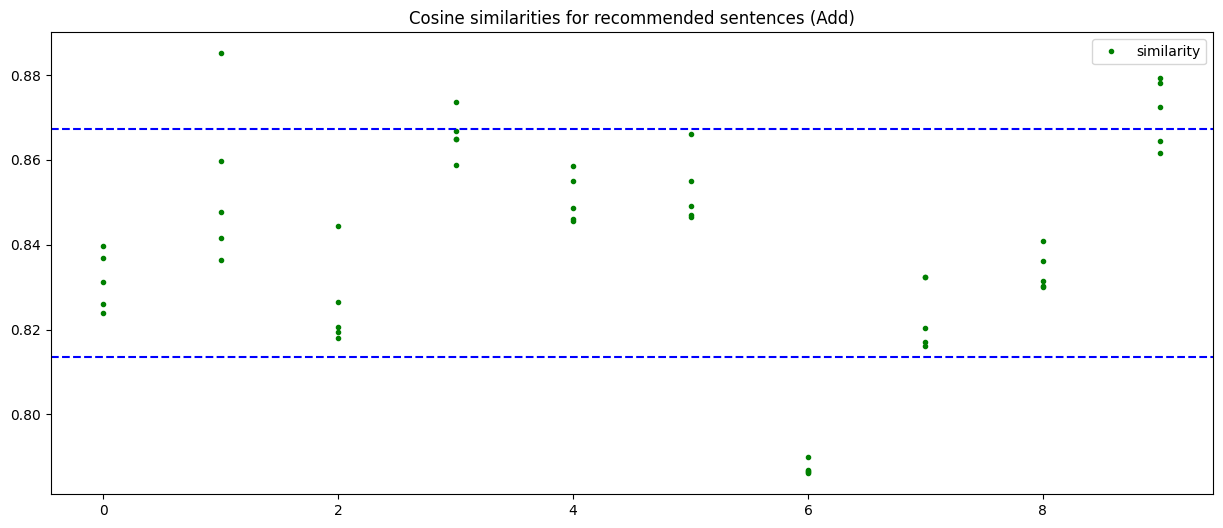

       similarity
count   50.000000
mean     0.849507
std      0.017857
min      0.829455
10%      0.834068
25%      0.838959
50%      0.844565
75%      0.854141
90%      0.870998
max      0.918137


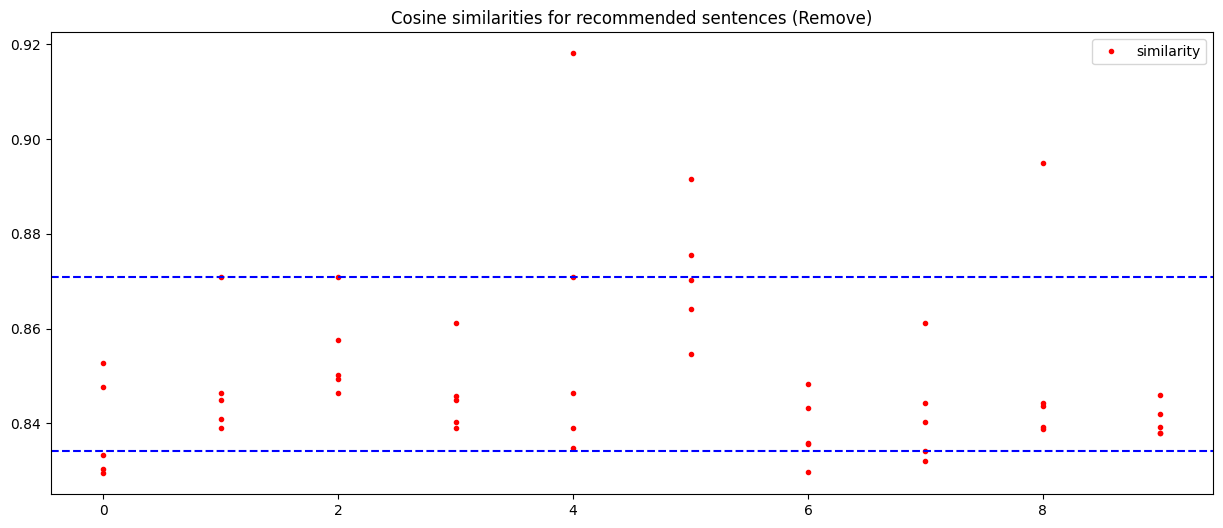

In [36]:
# thresholds = get_thresholds( test_prompts_df, 'Merged_Prompt', model_id, verbose=True )
thresholds = get_thresholds( test_prompts_df.sample(n=10), 'Merged_Prompt', model_id, verbose=True )

In [43]:
# Recommended thresholds given the provided sample prompts and selected sentence transformer
thresholds

{'add_lower_threshold': 0.8,
 'add_higher_threshold': 0.9,
 'remove_lower_threshold': 0.8,
 'remove_higher_threshold': 0.9}

In [44]:
# Enter your prompt here
prompt = test_prompts_df['Merged_Prompt'][0]

In [46]:
out = recommend_prompt( 
    prompt, 
    thresholds['add_lower_threshold'], 
    thresholds['add_higher_threshold'], 
    thresholds['remove_lower_threshold'], 
    thresholds['remove_higher_threshold'], 
    model_id 
)
print( prompt )
print( json.dumps( out, indent=4 ) )

Act as a professional data scientist with 20 years of experience studying consumer behavior. Here is a csv file with bank records from 800,000 Americans. Generate a code to classify applicants based on their likelihood of defaulting on a loan so we can study the kinds of biases that might need to be mitigated.
{
    "input": [],
    "add": [
        {
            "value": "progress",
            "prompt": "Could you help us identify any potential biases in this dataset and suggest ways to mitigate them?",
            "similarity": 0.8563613308533783,
            "x": "-6.970839",
            "y": "9.686985"
        },
        {
            "value": "openness",
            "prompt": "Write a code to help the machine learning model be more accessible to users with disabilities, and to accommodate a range of accessibility needs.",
            "similarity": 0.8535636837058683,
            "x": "-8.532644",
            "y": "9.190053"
        },
        {
            "value": "fairness",
  